# Saliency
Example of saliency maps from [OpenVINO](https://docs.openvino.ai/2024/notebooks/clip-language-saliency-map-with-output.html#interactive-demo-with-gradio)

In [1]:
from pathlib import Path
from typing import Tuple, Union, Optional
import requests

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

In [2]:
model_checkpoint = "openai/clip-vit-base-patch16"

model = CLIPModel.from_pretrained(model_checkpoint).eval()
processor = CLIPProcessor.from_pretrained(model_checkpoint)

In [3]:
def get_random_crop_params(image_height: int, image_width: int, min_crop_size: int) -> Tuple[int, int, int, int]:
    crop_size = np.random.randint(min_crop_size, min(image_height, image_width))
    x = np.random.randint(image_width - crop_size + 1)
    y = np.random.randint(image_height - crop_size + 1)
    return x, y, crop_size


def get_cropped_image(im_tensor: np.array, x: int, y: int, crop_size: int) -> np.array:
    return im_tensor[y : y + crop_size, x : x + crop_size, ...]


def update_saliency_map(saliency_map: np.array, similarity: float, x: int, y: int, crop_size: int) -> None:
    saliency_map[
        y : y + crop_size,
        x : x + crop_size,
    ] += similarity


def cosine_similarity(one: Union[np.ndarray, torch.Tensor], other: Union[np.ndarray, torch.Tensor]) -> Union[np.ndarray, torch.Tensor]:
    return one @ other.T / (np.linalg.norm(one) * np.linalg.norm(other))

### Compute

Images are generater using AI. Create your own and substitute the paths.

In [4]:
n_iters = 1500
min_crop_size = 50

query = "who is the author of this painting?"
modigliani = "/Users/Flint/Pictures/AI/DrawThings/create_a_color_painting_of_a_woman_in_the_style_of_amedeo_modigliani_983775299.png"
monet = "/Users/Flint/Pictures/AI/DrawThings/create_a_color_landscape_in_the_style_of_claude_monet_745053692.png"
vangogh = "/Users/Flint/Pictures/AI/DrawThings/create_a_color_landscape_in_the_style_of_vincent_van_gogh_1018549273.png"
image_path = modigliani

image = Image.open(image_path).convert("RGB")
im_tensor = np.array(image)

x_dim, y_dim = image.size

print(f"Image of size {x_dim} X {y_dim}")

Image of size 768 X 768


In [5]:
inputs = processor(text=[query], images=[im_tensor], return_tensors="pt")
with torch.no_grad():
    results = model(**inputs)
results.keys()

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

In [6]:
inputs = processor(text=[query], images=[im_tensor], return_tensors="pt")
with torch.no_grad():
    results = model(**inputs)
text_embeds = results.text_embeds  # save text embeddings to use them later

initial_similarity = cosine_similarity(text_embeds, results.image_embeds).item()
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)

    image_inputs = processor(images=[im_crop], return_tensors="pt")  # crop preprocessing
    with torch.no_grad():
        image_embeds = model.get_image_features(**image_inputs)  # calculate image embeddings only

    similarity = cosine_similarity(text_embeds, image_embeds).item() - initial_similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)

  0%|          | 0/1500 [00:00<?, ?it/s]

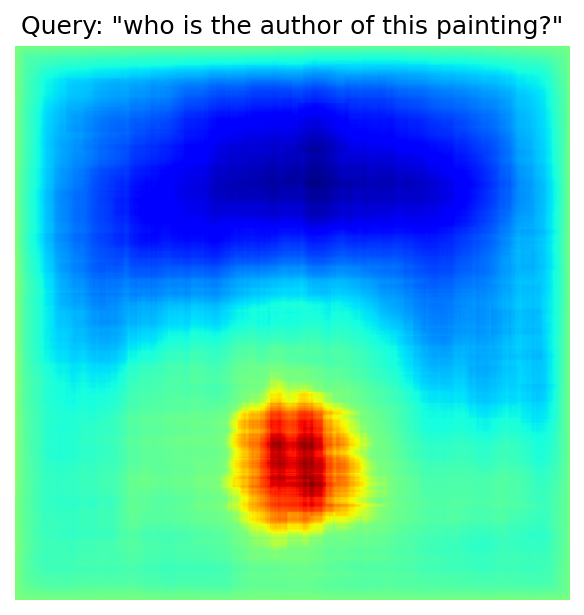

In [7]:
plt.figure(dpi=150)
plt.imshow(saliency_map, norm=colors.TwoSlopeNorm(vcenter=0), cmap="jet")
plt.title(f'Query: "{query}"')
plt.axis("off")
plt.show()

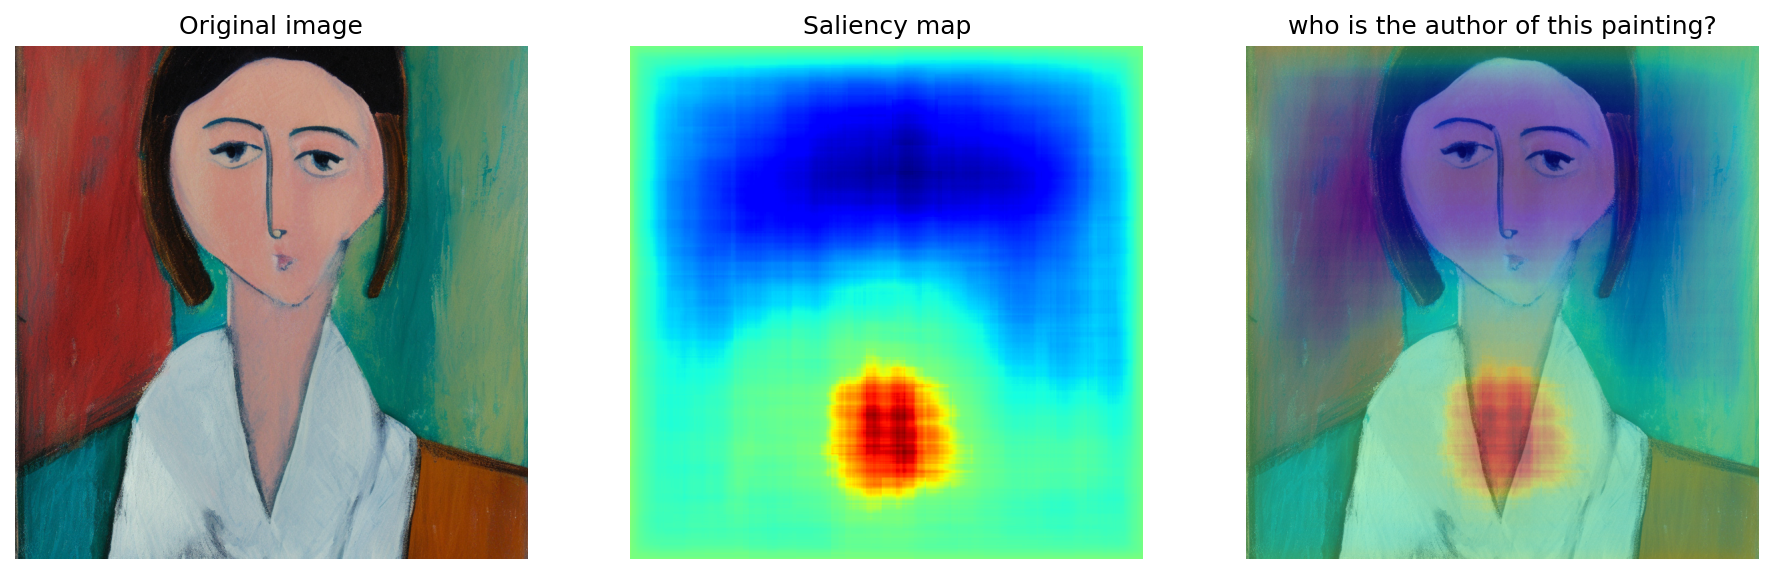

In [8]:
def plot_saliency_map(image_tensor: np.ndarray, saliency_map: np.ndarray, query: Optional[str]) -> None:
    fig = plt.figure(dpi=150)
    plt.imshow(image_tensor)
    plt.imshow(
        saliency_map,
        norm=colors.TwoSlopeNorm(vcenter=0),
        cmap="jet",
        alpha=0.4,  # make saliency map trasparent to see original picture
    )
    if query:
        plt.title(f'Query: "{query}"')
    plt.axis("off")
    plt.show()

def plot_combined(image_tensor: np.ndarray, saliency_map: np.ndarray, query: Optional[str]):
    fig, ax = plt.subplots(dpi=150, ncols=3, figsize=(15, 5))
    ax[0].imshow(image_tensor)
    ax[0].set_title("Original image")
    ax[0].axis('off')
    ax[1].imshow(saliency_map, norm=colors.TwoSlopeNorm(vcenter=0), cmap="jet")
    ax[1].set_title("Saliency map")
    ax[1].axis('off')
    ax[2].imshow(image_tensor)
    ax[2].imshow(saliency_map, norm=colors.TwoSlopeNorm(vcenter=0), cmap="jet", alpha=0.4)
    ax[2].set_title(query)
    ax[2].axis('off')


plot_combined(im_tensor, saliency_map, query)